## Mixed-Curvature SNE

In [1]:
# from tsne import *
from sklearn.manifold import TSNE
from htsne_impl import *
from pvae.datasets import datasets
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

### Re-create t-SNE visualization on MNIST

Loaded MNIST data with shape: (1000, 784)
Number of classes: 10


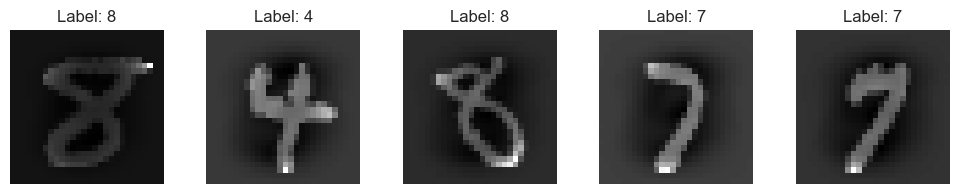

In [2]:
"""
Data preprocessing pipeline for MNIST dataset:
1. Loads MNIST as initial benchmark dataset (consistent with original t-SNE paper)
2. Applies StandardScaler to normalize features (important for distance calculations)
3. Includes visualization check for data integrity

Key Features:
- Configurable sample size for development/testing
- Reproducible sampling with random_state
- Float32 conversion for computational efficiency

This implementation serves as our baseline dataset before moving to more complex
hierarchical and network data structures mentioned in the proposal.
"""

def load_mnist(n_samples=1000, random_state=42):
    """
    Load and preprocess MNIST dataset

    Parameters:
    -----------
    n_samples : int
        Number of samples to load
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    X : array of shape (n_samples, n_features)
        The input data
    y : array of shape (n_samples,)
        The labels
    """
    # Load MNIST
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert to float32 for faster processing
    X = X.astype('float32')

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Subsample if needed
    if n_samples < X.shape[0]:
        np.random.seed(random_state)
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y

# Load a subset of MNIST for initial testing
X_mnist, y_mnist = load_mnist(n_samples=1000)

print(f"Loaded MNIST data with shape: {X_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

# Visualize a few digits to verify the data
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_mnist[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_mnist[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
tsne = TSNE(n_components=2,
            perplexity=30,
            random_state=42,
            init='pca')
X_tsne = tsne.fit_transform(X_mnist)

In [ ]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                        c=y_mnist.astype(int),
                        cmap='tab10',
                        alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of MNIST digits')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

### Re-create CO-SNE visualization on synthetic point clusters

### Create hyperspherical data from wrapped normal distribution and generate visualization

### Create S^2 x E^2 x H^2 product space from wrapped normal distribution, and generate three separate 2D visualizations